# Aquifer Storage and Recovery with MODFLOW6
David Haasnoot, Justin van Beek

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp
import glob
import imageio
import IPython
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import datetime
import xarray as xr

## Description of the flow problem
Consider radial flow in a confined aquifer. The aquifer extends in the $r$ direction from $r=0$ to $r=R$, where $R$ is chosen far enough away not to effect the solution.  Water is injected by the well at a rate $Q$. The head is fixed at $r=R$ to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and last for $t_\text{in}$ days, after which water is extracted at the same rate $Q$ for $t_\text{out}$ days.

The parameter block is similar to the parameter block for one-dimensional (linear) flow. Some values are chosen differently, such as the time of injection. The values of the hydraulic conductivity and porosity are converted so that MODFLOW can be used to simulate radial flow (see Langevin, 2008).

In [2]:
Q_d = 40_000
Q_tot = Q_d * 1 ## Change this later as we actually want to produce this, currentlty we still have 80% loss
d_extrating = 62
d_injecting = 365 - d_extrating ## change later for days with water excess
print(f'Need to pump {Q_tot/d_extrating:.2f}m^3/d to full fill demand') 

Need to pump 645.16m^3/d to full fill demand


In [3]:
# domain size and boundary conditions
R = 200 # length of domain, m
hR = 0 # head at r=R
hL = hR

# aquifer parameters
k = 30 # hydraulic conductivity, m/d -> between 10 - 40: start with 30
H = 20 # aquifer thickness, m
npor = 0.35 # porosity, generally 0.25- 0.5 

# flow

Q_out = Q_tot/d_extrating # extraction rate, m^3/d 
Q_in = Q_tot / (d_injecting)# injection rate m^3/d

# transport
alphaL = 0.5 # longitudinal dispersivity in horizontal direction, m - ###################### something to check!! -> slides guest lecture
alphaT = alphaL / 10 # transverse dispersivity in horizontal direction, m
diffusion_coef = 0 # diffusion coeffcient

# concentration
cs = 30 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# buoyancy
rhoref = 1000 # reference density, kg/m^3
cref = 0 # reference concentration, kg/m^3
drhodc = 0.7143  # Slope of the density-concentration line

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m

############################### Number of  layers! #################
nlay = 20 # number of layers

z = np.linspace(0, -H, nlay + 1) # top and bottom(s) of layers
zc = 0.5 * (z[:-1] + z[1:]) # center so cells, used for contouring
nrow = 1 # number of rows
ncol = round(R / delr) # number of columns
rw = 0.2 # radius of well, m

# convert parameters for radial flow following procedure of Langevin, 2008
# radialize parameters:
theta = 2 * np.pi
r = np.cumsum(delr * np.ones(ncol)) - 0.5 * delr # rightside of cell minus half the cell length
krad = k * r * theta * np.ones((nlay, nrow, ncol))
nporrad = npor * r * theta * np.ones((nlay, nrow, ncol))

# time discretization
########## injection
tin = d_injecting # injection time, d - rest of the year - maybe change later
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer

######### extraction
tout = d_extrating # extraction time, d
delt = 0.1 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

# model name and workspace
modelname = 'modelrad_khv' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used

In [4]:
print(f'injection rate is {Q_in:.0f}m^3/d, extraction is {Q_out:.0f}m^3/d')
print(f'injection rate is {Q_in/24:.0f}m^3/h, extraction is {Q_out/24:.0f}m^3/h')

injection rate is 132m^3/d, extraction is 645m^3/d
injection rate is 6m^3/h, extraction is 27m^3/h


## Create Simulation

In [5]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # absolute path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
<!-- Changes in the groundwater flow model:
* Use the converted value of $k$ in the npf package and use the logarithmic averaging option to compute cell-by-cell hydraulic conductivities.
* Use the discharge $Q$ in the well package. -->

In [6]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                             inner_dvclose=1e-6
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=krad, # horizontal k value
                                k33=krad / 10,
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = []
wellout = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0),  Q_in / nlay, cf])  # [(layer, row, col), U, concentration]
    wellout.append([(ilay, 0, 0),  -Q_out / nlay, cf]) # specified concentration is not used, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd = []
for ilay in range(nlay):
    chd.append([(ilay,  0,  ncol-1), hL, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd, 1: chd}    # Stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )

# buoyancy
buy = fp.mf6.ModflowGwfbuy(model=gwf,
                           packagedata=[0, drhodc, cref, gwtname, 'CONCENTRATION'], # [conc 1 species - 0= salt, drhodc, cref, gwtname, name]
                           denseref=rhoref, # reference concentration
                           nrhospecies=1, # number of species
                           density_filerecord=f"{gwf.name}.dst", # file name
                           pname='BUY1', 
                          )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
<!-- Changes in the transport model: Use the converted value of the porosity in the mst package. -->

In [7]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim,
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                             inner_dvclose=1e-6
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, 
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=nporrad, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")]
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD",  # use Total Variation Diminishing (TVD)
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL,
                           ath1=alphaT, 
                           diffc=diffusion_coef,
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

In [8]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name , 
                     exgmnameb=gwt.name , 
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model

In [9]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read concentration data

<!-- Plot the concentration vs. $r$ at 10 day intervals. Make separate plots for the injection and extraction periods. -->

In [10]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

Text(0, 0.5, 'd (m)')

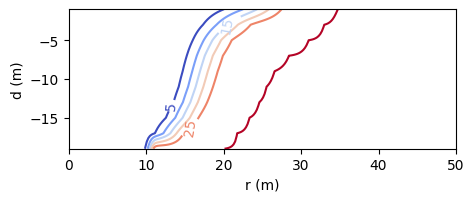

In [11]:
plt.subplot(111, aspect=1)
i = 500
contour = plt.contour(r, zc, c[i], np.arange(5, 35, 5), cmap='coolwarm')
plt.clabel(contour, contour.levels[::2], inline=True, fontsize=10)
plt.xlim(0, 50)
plt.xlabel('r (m)')
plt.ylabel('d (m)')

In [12]:
from ipywidgets import interact
import warnings
warnings.simplefilter("ignore")
def contour(tstep):
    plt.subplot(111, xlim=(0, 50), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
    plt.contour(r, zc, c[tstep], np.arange(5, 35, 5), cmap='coolwarm')

interact(contour, tstep=(0, nstepin + nstepout - 1, 1));

interactive(children=(IntSlider(value=1824, description='tstep', max=3649), Output()), _dom_classes=('widget-i…

## Mass balance

In [13]:
itime_out = np.abs(times - tin).argmin()
lst_delM1 = []
lst_delM2 = []
for layer_i in range(nlay):
    delM1 = np.zeros(len(times))
    delM2 = np.zeros(len(times))
    for index, t in enumerate(times):
        itime = np.abs(times - t).argmin() # find index of value in times closest to t
        # skip first timestep as itime-1 doesn't exisit
        if itime == 0:
            delM1[itime] = np.nan
            delM2[itime] = np.nan
        else:
            # change based on in flow or outflow 
            if itime <= itime_out:
                # inflow
                delM1[index] = (Q_in/nlay * c[itime, layer_i, 0] -  Q_in/nlay * c[itime, layer_i, -1]) * delt
            else:
                # outflow
                delM1[index] = (- Q_out/nlay * c[itime, layer_i, 0] + Q_out/nlay * c[itime, layer_i, -1]) * delt
            delM2_i = 0
            for index_r, r_i in enumerate(r):
                radius_centre = r_i
                radius_left = radius_centre - 0.5 * delr
                radius_right = radius_centre + 0.5 * delr
                delM2_i += (c[itime,layer_i,index_r] - c[itime - 1,layer_i,index_r]) * (radius_right**2 - radius_left**2) * H/nlay * np.pi * npor
            delM2[index] = delM2_i
        
    lst_delM1.append(delM1)
    lst_delM2.append(delM2)

In [14]:
delM1_sum = np.vstack(lst_delM1).sum(axis=0)
delM2_sum = np.vstack(lst_delM2).sum(axis=0)

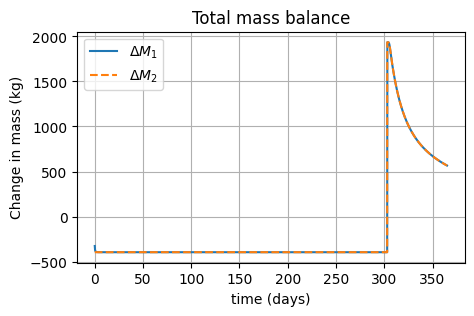

In [15]:
plt.plot(times, delM1_sum, label=r'$\Delta M_1$')
plt.plot(times, delM2_sum, label=r'$\Delta M_2$',ls="--")
plt.legend()
plt.title('Total mass balance')
plt.xlabel('time (days)')
plt.ylabel('Change in mass (kg)');
plt.grid()
plt.savefig(rf'figures\difference_in_total_mass_balance_for_{nlay}_layers.png',bbox_inches="tight")

In [16]:
print(f'In the last timestep of extraction the mass balance is {delM1_sum[-1]:.2f}kg for ΔM1 & {delM2_sum[-1]:.2f}kg for ΔM2')

In the last timestep of extraction the mass balance is 566.23kg for ΔM1 & 565.99kg for ΔM2


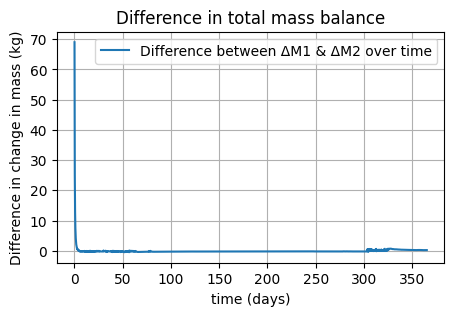

In [17]:
diff = delM1_sum - delM2_sum
plt.plot(times, diff, label="Difference between ΔM1 & ΔM2 over time")
plt.legend()
plt.title('Difference in total mass balance')
plt.xlabel('time (days)')
plt.ylabel('Difference in change in mass (kg)');
plt.grid()
plt.savefig(rf'figures\difference_in_total_mass_balance_for_{nlay}_layers.png',bbox_inches="tight")

In [18]:
climit = 1 # limit concentration, g/L
t_begin_index = nstepin
t_end_index = len(times)

In [19]:
for itime in range(t_begin_index, t_end_index):
    if c[itime,:, 0].mean() > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime,:, 0].mean():.2f} g/L')

if t_end_index == times[itime]:
    print(f'recovery efficiency = 100%')
else:
    rec_eff = ((times[itime - 1] - tin) * Q_out) / (tin * Q_in) # Qs needed as injection and extraction rates are not the same
    print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 306.0 d when concentration is 1.09 g/L
recovery efficiency = 4.7 %


### Compute the recovery efficiency for many  cycles

In [20]:
from flopy.mf6.mfbase import VerbosityLevel
sim.simulation_data.verbosity_level = VerbosityLevel.quiet

In [21]:
run = True # takes long
if run: 
    time_break_lst = []
    rec_eff_lst = []
    n_years = 10
    cycle_n = np.arange(0, n_years,1)
    c_arr = np.zeros((len(cycle_n)+1,nlay, ncol))
    c_store_all = np.zeros((len(cycle_n), nstepin+nstepout,nlay,ncol))
    c_arr[0] = np.ones((nlay,ncol)) * cs
    c_prev = cs

    now = datetime.datetime.now()
    print(f'Start {nlay} layers at {now.hour}:{now.minute}')
    end = now + datetime.timedelta(minutes=(nlay-5)*n_years)
    print(f'Expected runtime end at {end.hour}:{end.minute}')
    for index_cycle in tqdm(cycle_n):
        # initial condition from prev time period
        gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                                     strt=c_arr[index_cycle], # initial concentration
                                     ) 
        # here also change the injection after the first two years. 
    
        
        # write model, solve model, and read concentration data
        sim.write_simulation(silent=True)
        success, _ = sim.run_simulation(silent=True) 
        if success == 1:
            # print(f'Model solved successfully for {index_cycle}', end="\r")
            pass
        else:
            print('Solve failed')
            break
        
        cobj = gwt.output.concentration() # get handle to binary concentration file
        c_i = cobj.get_alldata().squeeze() # get the concentration data from the file
        for itime in range(t_begin_index, t_end_index):
            if c_i[itime,:, 0].mean() > climit:
                time_break_lst.append(itime)
                break
    
        c_arr[index_cycle+1] = c_i[itime - 1,:]
        c_store_all[index_cycle] = c_i
        rec_eff = ((times[itime - 1] - tin) * Q_out) / (tin * Q_in) # Q  needed as injection and extraction rates are not the same
        rec_eff_lst.append(rec_eff*100)

Start 10 layers at 16:48
Expected runtime end at 17:38


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:16:40<00:00, 460.01s/it]


## store files

In [22]:
n_years = 10
run = True

In [23]:
if run:    
    time = str(datetime.datetime.now())[:-10].replace(":","_")
    fname = fr'output/store_concentrations_k-{k}_npor-{npor}_alphaL-{alphaL}-nlay-{nlay}_{time}.nc'
    ds = xr.DataArray(c_store_all,dims=['year','tstep','layer','r'])
    ds.to_netcdf(fname,engine="netcdf4")

fname_in = fr'output/store_concentrations_k-{k}_npor-{npor}_alphaL-{alphaL}-nlay-{nlay}_*.nc'
files = glob.glob(fname_in)[0]
ds_in = xr.open_dataarray(files)
# n_years = 3

In [24]:
from ipywidgets import interact
import warnings
warnings.simplefilter("ignore")
def contour(tstep,year):
    data = ds_in.isel(year=year-1,tstep=tstep)
    plt.subplot(111, xlim=(0, 100), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
    cls = plt.contour(r, zc, data, np.arange(5, 35, 5), cmap='coolwarm')
    plt.clabel(cls, cls.levels[::2], inline=True, fontsize=10)
 
interact(contour, tstep=(0, nstepin + nstepout - 1, 1),year=(1,n_years,1));

interactive(children=(IntSlider(value=1824, description='tstep', max=3649), IntSlider(value=5, description='ye…

# Recovery

In [25]:
print(f'The recovery efficiency after the first cycle is {rec_eff_lst[0]:.2f}% and after the second is {rec_eff_lst[1]:.2f}%')

The recovery efficiency after the first cycle is 4.68% and after the second is 5.16%


In [26]:
# from ipywidgets import interact
# import warnings
# warnings.simplefilter("ignore")
# def contour(tstep,year):
#     plt.subplot(111, xlim=(0, 100), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
#     cls = plt.contour(r, zc, c_store_all[year][tstep], np.arange(5, 35, 5), cmap='coolwarm')
#     plt.clabel(cls, cls.levels[::2], inline=True, fontsize=10)
 
# interact(contour, tstep=(0, nstepin + nstepout - 1, 1),year=(0,n_years-1,1));

In [27]:
rec_eff_lst

[4.6774193548404135,
 5.16129032258246,
 5.645161290324504,
 5.967741935485868,
 6.290322580647232,
 6.612903225808596,
 6.774193548389277,
 7.096774193550641,
 7.258064516131323,
 7.419354838712006]

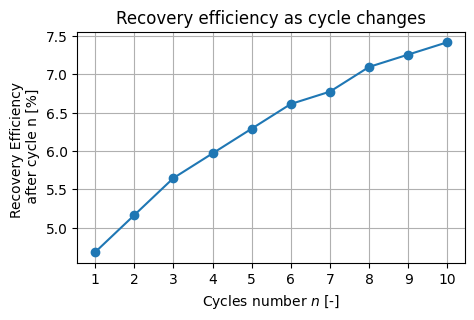

In [28]:
fname = r"figures/recovery_eff_cycles.png"
if run: 
    cycle_n_arr = np.array(cycle_n) + 1
    plt.plot(cycle_n_arr,rec_eff_lst,marker="o")
    plt.ylabel("Recovery Efficiency \n after cycle n [%]")
    plt.xlabel(r"Cycles number $n$ [-]")
    plt.title(r"Recovery efficiency as cycle changes")
    plt.xticks(ticks=cycle_n_arr)
    plt.grid()
    plt.savefig(fname)
else: 
    img = matplotlib.image.imread(fname)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis("off")

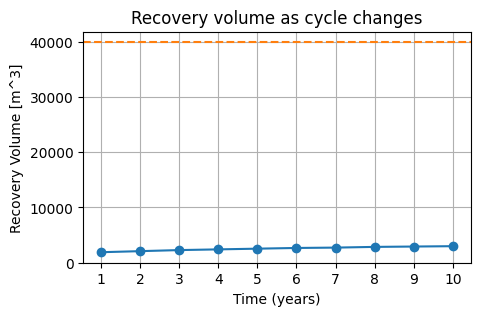

In [29]:
fname = r"figures/recovery_Q_cycles.png"
# run = True
if run: 
    cycle_n_arr = np.array(cycle_n) + 1
    rec_eff_arr = np.array(rec_eff_lst)
    plt.plot(cycle_n_arr,rec_eff_arr*Q_tot/100,marker="o")
    plt.axhline(Q_d,ls="--",color="C1",label="Design production volume")
    plt.ylabel("Recovery Volume [m^3]")
    plt.xlabel(r"Time (years)")
    plt.title(r"Recovery volume as cycle changes")
    plt.xticks(ticks=cycle_n_arr)
    plt.grid()
    plt.savefig(fname,bbox_inches="tight")
else: 
    img = matplotlib.image.imread(fname)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis("off")

In [30]:
len(times)

3650

Text(0, 0.5, 'd (m)')

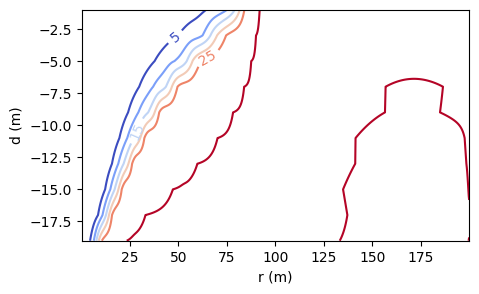

In [31]:
c_i = c_store_all[0]
# plt.subplot(111, aspect=1)
i = 3650-10*60
contour = plt.contour(r, zc, c_i[i], np.arange(5, 35, 5), cmap='coolwarm')
plt.clabel(contour, contour.levels[::2], inline=True, fontsize=10)
# plt.xlim(0, 50)
plt.xlabel('r (m)')
plt.ylabel('d (m)')

### Make GIFS

In [32]:
import matplotlib
cmap1 = matplotlib.cm.tab10
cmap2 = matplotlib.cm.tab20

In [33]:
# i = 5
# plt.plot(0,0,marker="*",color=cmap1((i)/10))
# plt.plot(0,1,marker="*",color=cmap2((i/10)+0.05))

In [34]:
# run = True # takes long
# keep_prev_years = False

# if keep_prev_years: fname = r'figures/overview_years.gif'
# else: fname = r'figures/overview_per_year.gif'

# if run: 
#     if keep_prev_years: plt.figure(figsize=(12, 3))
#     for i in cycle_n:
#         c_i = c_store_all[i]
#         if not keep_prev_years: plt.figure(figsize=(12, 3))
#         # plot concentration vs. x for three different times   
#         for t in np.arange(10, 365, 10):
#             itime = np.abs(times - t).argmin() # find index of value in times closest to t
#             if itime < itime_out:
#                 plt.title(f'Year {i+1}, t={t}d (injection)')
#                 color = cmap2((i/10)+0.05)
#                 alpha = 0.5
#             else:
#                 plt.title(f'Year {i+1}, t={t}d (extraction)')
#                 color = cmap1((i)/10)
#                 alpha = 0.99
    
#             plt.plot(r, c_i[itime,:], color=color,alpha=alpha) #, label=f't={times[itime]:.0f} d')
#             plt.xlabel('r (m)')
#             plt.ylabel('concentration (g/L)')
#             plt.xlim(0, 80)
#             # plt.legend(loc='lower right')
#             # plt.grid()
#             if t < 100: t_name = f'0{t}'
#             else: t_name = f'{t}'
#             if i < 9: i_name = f'0{i+1}'
#             else: i_name = f'{i+1}'
#             plt.savefig(rf"figures/overview_year_{i_name}_{t_name}.png",bbox_inches="tight")
#         if not keep_prev_years: plt.close()
#     if keep_prev_years: plt.close()
    
    
#     figs =  glob.glob("figures/overview_year_*.png")
#     speed = 20
#     with imageio.get_writer(fname, mode='I',duration=5) as writer:
#         for fig in figs:
#             image = imageio.v3.imread(fig)
#             for i in range(speed):
#                 writer.append_data(image)

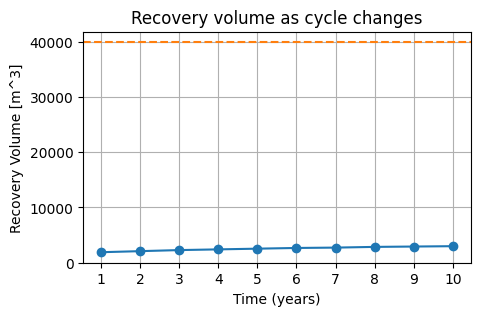

In [35]:
IPython.display.Image(filename=fname)

In [36]:
fname

'figures/recovery_Q_cycles.png'

# Image for presentation

In [37]:
import datetime
import pandas as pd
import matplotlib.dates as mdates

In [38]:
d_july = 153
lst = [Q_tot/d_injecting] * d_july
lst += [-Q_tot/d_extrating] * d_extrating
lst += [Q_tot/d_injecting] * (d_injecting - d_july)
d1 = datetime.date(2023, 1, 1)
d2 = datetime.date(2023, 12, 31)
days = [d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)]

In [39]:
df = pd.DataFrame(data=np.array([days,lst]).T,columns=["date","Q"])
df['Timestamp'] = df['date'].apply(lambda x: pd.Timestamp(x))
df.set_index('Timestamp', inplace=True, drop=True)

In [40]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

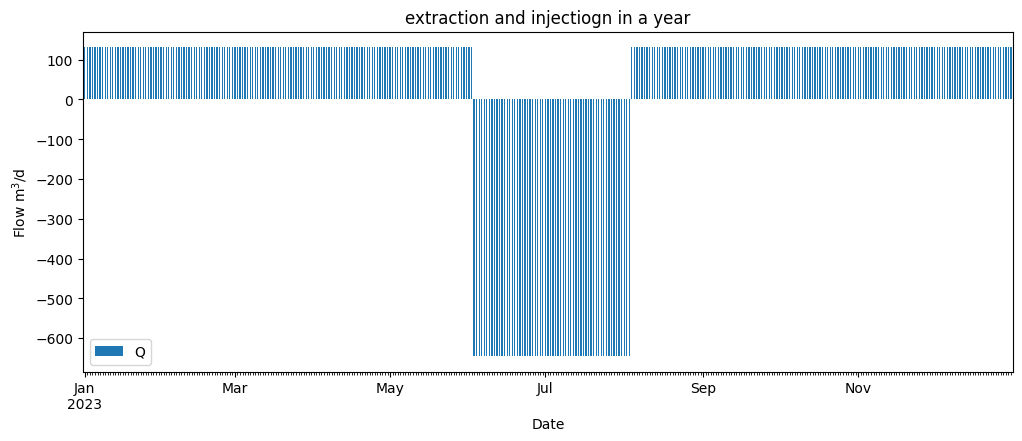

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# df_months = df[['Q']].resample("M").sum()
df[['Q']].plot(kind="bar",ax=ax,stacked=True)


#############from https://stackoverflow.com/questions/30133280/pandas-bar-plot-changes-date-format#########
# Compute width of bars in matplotlib date units, 'md' (in days) and adjust it if
# the bar width in df.plot.bar has been set to something else than the default 0.5
bar_width_md_default, = np.diff(mdates.date2num(df.index[:2]))/2
bar_width = ax.patches[0].get_width()
bar_width_md = bar_width*bar_width_md_default/0.5

# Compute new x values in matplotlib date units for the patches (rectangles) that
# make up the stacked bars, adjusting the positions according to the bar width:
# if the frequency is in months (or years), the bars may not always be perfectly
# centered over the tick marks depending on the number of days difference between
# the months (or years) given by df.index[0] and [1] used to compute the bar 
# width, this should not be noticeable if the bars are wide enough.
x_bars_md = mdates.date2num(df.index) - bar_width_md/2
nvar = len(ax.get_legend_handles_labels()[1])
x_patches_md = np.ravel(nvar*[x_bars_md])

# Set bars to new x positions and adjust width: this loop works fine with NaN
# values as well because in bar plot NaNs are drawn with a rectangle of 0 height
# located at the foot of the bar, you can verify this with patch.get_bbox()
for patch, x_md in zip(ax.patches, x_patches_md):
    patch.set_x(x_md)
    patch.set_width(bar_width_md)

# Set major ticks
maj_loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(maj_loc)

# Show minor tick under each bar (instead of each month) to highlight
# discrepancy between major tick locator and bar positions seeing as no tick
# locator is available for first-week-of-the-month frequency
ax.set_xticks(x_bars_md + bar_width_md/2, minor=True)

# Set major tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(fmt)

# Shift the plot frame to where the bars are now located
xmin = min(x_bars_md) - bar_width_md
xmax = max(x_bars_md) + 2*bar_width_md
ax.set_xlim(xmin, xmax)

# Adjust tick label format last, else it may sometimes not be applied correctly
ax.figure.autofmt_xdate(rotation=0, ha='center')
#######################################3
ax.set_ylabel("Flow m$^3$/d");
ax.set_title('extraction and injectiogn in a year')
ax.set_xlabel("Date")
plt.savefig(rf"figures/Injection_extraction_scheme.png",bbox_inches="tight")